<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap6/setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import numpy as np

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [52]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

x_test = test_dataset.test_data.cpu().numpy()
y_test = test_dataset.test_labels.cpu().numpy()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Dataloader Arguments & Test/Train Dataloaders


In [53]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
print(dataloader_args)
# train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

CUDA Available? True
{'shuffle': True, 'batch_size': 128, 'num_workers': 4, 'pin_memory': True}


**Data Statistics**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


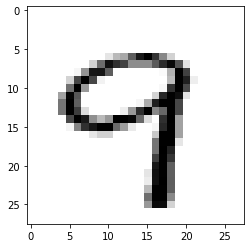

In [54]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_dataset.train_data
train_data = train_dataset.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_dataset.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_dataset.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape) # Each sample image is 28x28

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

**Model**

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_value = 0.03
        self.conv_layer1 = nn.Sequential(                      
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 26, RF = 3
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            #nn.Dropout2d(self.dropout_value)
        )
        self.conv_layer2 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 24, RF = 5
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            #nn.Dropout2d(self.dropout_value)
        )
        self.maxpool_layer1 = nn.MaxPool2d(kernel_size=(2,2)) #Op_size = 12, RF = 6
        self.conv_layer3 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 10, RF = 10   
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14),
            #nn.Dropout2d(self.dropout_value)
        )
        self.conv_layer4 = nn.Sequential(  
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 8, RF = 14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            #nn.Dropout2d(self.dropout_value) 
        )
        self.conv_layer5 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=True),#Op_size = 6, RF = 18 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            #nn.Dropout(self.dropout_value)
        )
        self.conv_layer6 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 6, RF = 22 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            #nn.Dropout(self.dropout_value)
        )            
        self.avgpool_layer1 = nn.AvgPool2d(kernel_size=6)

        self.conv_layer7 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=True)#Op_size = 1, RF = 28
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x =  self.maxpool_layer1(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.avgpool_layer1(x)
        x = self.conv_layer7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [55]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
            Conv2d-4           [-1, 12, 24, 24]           1,308
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
         MaxPool2d-7           [-1, 12, 12, 12]               0
            Conv2d-8           [-1, 14, 10, 10]           1,526
              ReLU-9           [-1, 14, 10, 10]               0
      BatchNorm2d-10           [-1, 14, 10, 10]              28
           Conv2d-11             [-1, 16, 8, 8]           2,032
             ReLU-12             [-1, 16, 8, 8]               0
      BatchNorm2d-13             [-1, 16, 8, 8]              32
           Conv2d-14             [

# Training 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train functions

In [0]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
def train_model(model, device, train_loader, optimizer, epoch):
  #print('\n total number of train_loader items', len(train_loader.dataset))
  #print('train_loader Claases', train_loader.dataset.classes)
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    regularization_loss  = 0
    for param in model.parameters():
        regularization_loss += l1_crit(param)
    factor = 0.0005
    loss += factor * regularization_loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred_train = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    train_correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    train_loss = loss.item()
    train_acc = 100. * train_correct / len(train_loader.dataset)
    pbar.set_description(desc= f'Epoch={epoch} Batch={batch_idx} Training Loss={loss.item()} Batch_id={batch_idx} Training Accuracy={100*correct/processed:0.2f}')
    
    return train_acc, train_loss

**Testing**

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write test functions

In [0]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
def test_model(model, device, test_loader,misclassify):
    #print('\n total number of test_loader items', len(test_loader.dataset))
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
      
            for i in range(len(pred)):
                if pred[i] != target[i]:
                   misclassify.append([data[i],pred[i],target[i]])

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_acc, test_loss


# Let's Train and test our model

In [0]:
def train_n_test(model, optimizer, device, train_data_loader, test_data_loader, num_epochs=10):
  train_acc_history = []
  train_loss_history = []
  test_acc_history = []
  test_loss_history = []

  for epoch in range(1,num_epochs+1):
    train_acc, train_loss = train_model(model, device, train_data_loader, optimizer, epoch)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    test_acc, test_loss = test_model(model, device, test_data_loader)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)

  return ([(train_acc_history, train_loss_history),(test_acc_history, test_loss_history)])


In [59]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
train_acc_history = []
train_loss_history = []
test_acc_history = []
test_loss_history = []

[(train_acc_1, train_loss_1), (test_acc_1, test_loss_1)] = train_n_test(model, optimizer, device, train_loader, test_loader, EPOCHS)

'''plot_acc_loss({'Setup': train_acc_1}, 
              {'Setup': test_acc_1},
              {'Setup': train_loss_1},
              {'Setup': test_loss_1}
             )'''







  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


TypeError: ignored

Plotting train accuracy, test accuracy, train loss and test loss

In [0]:
import numpy as np

from matplotlib import pyplot as plt

def plot_acc_loss(train_acc_series, test_acc_series, train_loss_series, test_loss_series):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  fig.suptitle("Training & Validation")

  for line in train_acc_series.items():
    axs[0, 0].plot(line[1], label=line[0])
  axs[0, 0].set_title("Training Accuracy")
  axs[0, 0].set_xlabel("Epoch")
  axs[0, 0].set_ylabel("Accuracy")
  axs[0, 0].legend()

  for line in train_loss_series.items():
    axs[0, 1].plot(line[1], label=line[0])
  axs[0, 1].set_title("Training Loss")
  axs[0, 1].set_xlabel("Epoch")
  axs[0, 1].set_ylabel("Loss")
  axs[0, 1].legend()

  for line in test_acc_series.items():
    axs[1, 0].plot(line[1], label=line[0])
  axs[1, 0].set_title("Validation Accuracy")
  axs[1, 0].set_xlabel("Epoch")
  axs[1, 0].set_ylabel("Accuracy")
  axs[1, 0].legend()

  for line in test_loss_series.items():
    axs[1, 1].plot(line[1], label=line[0])
  axs[1, 1].set_title("Validation Loss")
  axs[1, 1].set_xlabel("Epoch")
  axs[1, 1].set_ylabel("Loss")
  axs[1, 1].legend()